In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-rs/user_profile.csv
/kaggle/input/dataset-rs/raw_sample.csv
/kaggle/input/dataset-rs/UserBehavior.csv
/kaggle/input/dataset-rs/ad_feature.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Hyperparamètres
EMBEDDING_DIM = 32
BATCH_SIZE = 2048
EPOCHS = 5
LR = 0.001



In [4]:
print(EMBEDDING_DIM)

32


In [5]:
# Chargement des datasets
# source_data = pd.read_csv("/kaggle/input/dataset-rs/raw_sample.csv")  
# target_data = pd.read_csv("/kaggle/input/dataset-rs/UserBehavior.csv")
# target_data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']


def load_and_sample_data(source_path, target_path, sample_fraction=0.001):
    """
    Loads both source and target datasets and samples a given fraction.
    
    Parameters:
    - source_path (str): Path to the source dataset.
    - target_path (str): Path to the target dataset.
    - sample_fraction (float): Fraction of the dataset to use (e.g., 0.2 for 20%).

    Returns:
    - df_source_sampled (DataFrame): Sampled source dataset.
    - df_target_sampled (DataFrame): Sampled target dataset.
    """
    # Load datasets
    df_source = pd.read_csv(source_path)
    df_target = pd.read_csv(target_path)

    # Sample data
    df_source_sampled = df_source.sample(frac=sample_fraction, random_state=42)
    df_target_sampled = df_target.sample(frac=sample_fraction, random_state=42)

    return df_source_sampled, df_target_sampled

# Example usage: Adjust the fraction dynamically
sample_fraction = 0.01  # Change this to 0.3, 0.4, etc. based on your needs

source_data, target_data = load_and_sample_data("/kaggle/input/dataset-rs/raw_sample.csv", "/kaggle/input/dataset-rs/UserBehavior.csv", sample_fraction)

# Now df_source and df_target contain only the sampled data (no file saving)



print(f"Source dataset: {len(source_data)} rows")
print(f"Target dataset: {len(target_data)} rows")

target_data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']
source_data.rename(columns={"user": "user_id"}, inplace=True)

print("target data \n : ",target_data.head())
print("source data \n : ",source_data.head())


Source dataset: 265580 rows
Target dataset: 1001508 rows
target data 
 :            user_id  item_id  category_id behavior_type   timestamp
43314727   237858  1481482      2733371            pv  1512225772
88035904    44200  3916487      4135836            pv  1511931558
38200464   920479  1955086      2355072            pv  1512313496
83578910   239462  2698818       154040            pv  1511783539
78996463   947273  3511372      1029459            pv  1512273859
source data 
 :            user_id  time_stamp  adgroup_id          pid  nonclk  clk
22276667   506615  1494474498      570116  430548_1007       1    0
4373967    846189  1494470640      554740  430548_1007       1    0
4187248    601204  1494659172      542200  430539_1007       0    1
3102892    675220  1494426457      450876  430548_1007       1    0
9831068    756683  1494044138      160239  430548_1007       1    0


In [6]:
source_data_users = set(source_data['user_id'])
print("the number of the users in source data is : ", len(source_data_users))


target_data_users = set(target_data['user_id'])
print("the number of the users in target data is : ", len(target_data_users))

the number of the users in source data is :  168883
the number of the users in target data is :  528928


In [7]:
# Extraction des colonnes principales
source_users = source_data["user_id"].unique()
source_items = source_data["adgroup_id"].unique()

target_users = target_data["user_id"].unique()
target_items = target_data["item_id"].unique()

In [8]:
# Création des mappings (ID → Index)
user_map = {u: i for i, u in enumerate(np.union1d(source_users, target_users))}
item_map_source = {i: idx for idx, i in enumerate(source_items)}
item_map_target = {i: idx for idx, i in enumerate(target_items)}

In [9]:
# Conversion des données en indices
source_data["user_id"] = source_data["user_id"].map(user_map)
source_data["adgroup_id"] = source_data["adgroup_id"].map(item_map_source)

target_data["user_id"] = target_data["user_id"].map(user_map)
target_data["item_id"] = target_data["item_id"].map(item_map_target)

# Séparation des features et labels
X_target = target_data[["user_id", "item_id"]].values
y_target = target_data["behavior_type"].apply(lambda x: 1 if x == "buy" else 0).values

X_train, X_test, y_train, y_test = train_test_split(X_target, y_target, test_size=0.2, random_state=42)


In [58]:
# Définition du modèle
class RecommendationModel(nn.Module):
    def __init__(self, num_users, num_items_source, num_items_target, embedding_dim):
        super(RecommendationModel, self).__init__()
        
        # Embeddings partagés pour les utilisateurs
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        
        # Embeddings séparés pour les items
        self.item_embedding_source = nn.Embedding(num_items_source, embedding_dim)
        self.item_embedding_target = nn.Embedding(num_items_target, embedding_dim)
        
        # Réseau de couches entièrement connectées
        self.fc1 = nn.Linear(embedding_dim * 3, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, user_ids, item_ids, is_target=True):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding_target(item_ids) if is_target else self.item_embedding_source(item_ids)

        # Element-wise product as an additional feature
        element_product = user_emb * item_emb
    
        x = torch.cat([user_emb, item_emb, element_product], dim=1)
        x = self.bn1(torch.relu(self.fc1(x)))
        x = self.dropout1(x)
        x = self.bn2(torch.relu(self.fc2(x)))
        x = self.dropout2(x)
        x = self.bn3(torch.relu(self.fc3(x)))
        x = self.sigmoid(self.output(x))
        return x

In [59]:
# Initialisation du modèle
num_users = len(user_map)
num_items_source = len(item_map_source)
num_items_target = len(item_map_target)

model = RecommendationModel(num_users, num_items_source, num_items_target, EMBEDDING_DIM)

# Geler les embeddings utilisateurs (pas de mise à jour)
model.user_embedding.weight.requires_grad = False

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Conversion en tenseurs
X_train_tensor = torch.tensor(X_train, dtype=torch.long).cpu()
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).cpu()

In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader, TensorDataset


In [63]:
# Hyperparameters
EPOCHS = 30  # Change if needed
EMBEDDING_DIM = 64
LR = 0.001


best_loss = float('inf')
patience = 3
patience_counter = 0


# Initialize lists for loss & accuracy tracking
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
X_test_tensor = torch.tensor(X_test, dtype=torch.long).cpu()
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).cpu()

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)  # Try 1e-4 or 1e-3


# Training Loop
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    users, items = X_train_tensor[:, 0], X_train_tensor[:, 1]
    outputs = model(users, items, is_target=True)
    
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()
    
    train_losses.append(train_loss.item())

    # Compute Train Accuracy
    train_preds = (outputs >= 0.5).float()
    train_accuracy = (train_preds == y_train_tensor).float().mean().item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        users_test, items_test = X_test_tensor[:, 0], X_test_tensor[:, 1]
        test_outputs = model(users_test, items_test, is_target=True)
        
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())
        
        test_preds = (test_outputs >= 0.5).float()
        test_accuracy = (test_preds == y_test_tensor).float().mean().item()
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    
    if test_loss < best_loss:
        best_loss = test_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/30, Train Loss: 0.5109, Test Loss: 0.5006, Train Acc: 0.9799, Test Acc: 0.9621
Epoch 2/30, Train Loss: 0.5098, Test Loss: 0.4875, Train Acc: 0.9512, Test Acc: 0.9799
Epoch 3/30, Train Loss: 0.5022, Test Loss: 0.4838, Train Acc: 0.9791, Test Acc: 0.9798
Epoch 4/30, Train Loss: 0.4994, Test Loss: 0.4822, Train Acc: 0.9755, Test Acc: 0.9799
Epoch 5/30, Train Loss: 0.4943, Test Loss: 0.4808, Train Acc: 0.9790, Test Acc: 0.9799
Epoch 6/30, Train Loss: 0.4890, Test Loss: 0.4780, Train Acc: 0.9799, Test Acc: 0.9799
Epoch 7/30, Train Loss: 0.4847, Test Loss: 0.4737, Train Acc: 0.9798, Test Acc: 0.9799
Epoch 8/30, Train Loss: 0.4802, Test Loss: 0.4683, Train Acc: 0.9793, Test Acc: 0.9799
Epoch 9/30, Train Loss: 0.4756, Test Loss: 0.4629, Train Acc: 0.9793, Test Acc: 0.9799
Epoch 10/30, Train Loss: 0.4709, Test Loss: 0.4583, Train Acc: 0.9795, Test Acc: 0.9799
Epoch 11/30, Train Loss: 0.4662, Test Loss: 0.4543, Train Acc: 0.9797, Test Acc: 0.9799
Epoch 12/30, Train Loss: 0.4616, Test Los

In [64]:
# Convert tensors safely
y_test_np = y_test_tensor.cpu().numpy()
y_pred_np = test_preds.cpu().numpy()

# Compute Metrics
mse = mean_squared_error(y_test_np, y_pred_np)
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)
auc = roc_auc_score(y_test_np, y_pred_np)

# Compute Average Cosine Similarity on a subset
user_emb_matrix = model.user_embedding.weight.detach().cpu().numpy()
subset = user_emb_matrix[:500]  # Reduce size for memory efficiency
cosine_sim = cosine_similarity(subset)
avg_cosine_similarity = np.mean(cosine_sim)

print(f"\nMetrics:")
print(f"🔹 MSE: {mse:.4f}")
print(f"🔹 MAE: {mae:.4f}")
print(f"🔹 R² Score: {r2:.4f}")
print(f"🔹 AUC: {auc:.4f}")
print(f"🔹 Avg Cosine Similarity: {avg_cosine_similarity:.4f}")



Metrics:
🔹 MSE: 0.0201
🔹 MAE: 0.0201
🔹 R² Score: -0.0206
🔹 AUC: 0.5000
🔹 Avg Cosine Similarity: 0.0020


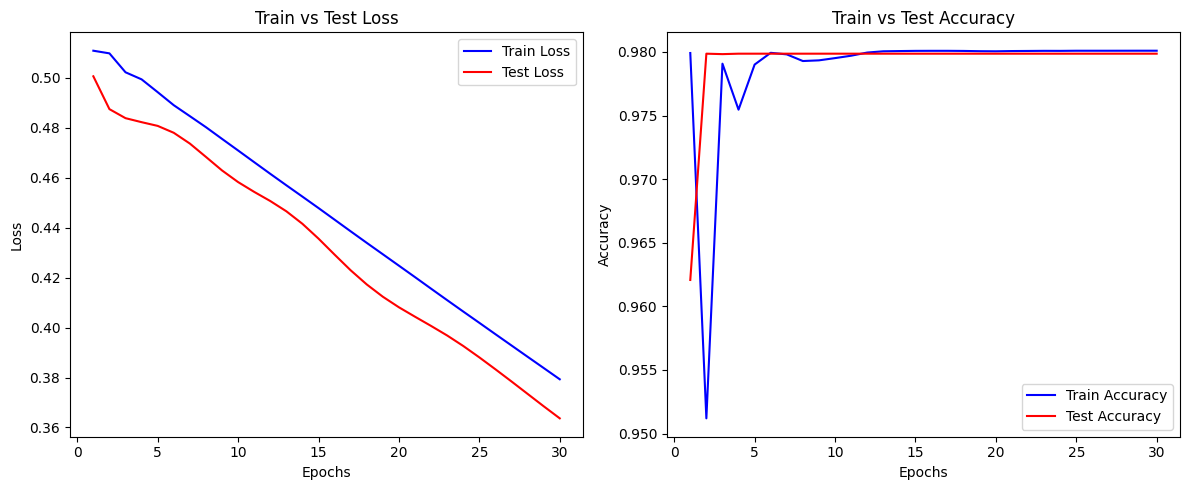

In [65]:
# Plot Loss (Train vs Test)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, len(test_losses)+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()

# Plot Accuracy (Train vs Test)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label="Test Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Entraînement
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    users, items = X_train_tensor[:, 0], X_train_tensor[:, 1]
    outputs = model(users, items, is_target=True)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

In [ ]:
# # Évaluation
# model.eval()
# X_test_tensor = torch.tensor(X_test, dtype=torch.long)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
# with torch.no_grad():
#     users, items = X_test_tensor[:, 0], X_test_tensor[:, 1]
#     predictions = model(users, items, is_target=True)
#     predictions = (predictions >= 0.5).float()
#     accuracy = (predictions == y_test_tensor).float().mean()
#     print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# here is the code that i use : 
# # Chargement des datasets
# # source_data = pd.read_csv("/kaggle/input/dataset-rs/raw_sample.csv")  
# # target_data = pd.read_csv("/kaggle/input/dataset-rs/UserBehavior.csv")
# # target_data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']


# def load_and_sample_data(source_path, target_path, sample_fraction=0.001):
#     """
#     Loads both source and target datasets and samples a given fraction.
    
#     Parameters:
#     - source_path (str): Path to the source dataset.
#     - target_path (str): Path to the target dataset.
#     - sample_fraction (float): Fraction of the dataset to use (e.g., 0.2 for 20%).

#     Returns:
#     - df_source_sampled (DataFrame): Sampled source dataset.
#     - df_target_sampled (DataFrame): Sampled target dataset.
#     """
#     # Load datasets
#     df_source = pd.read_csv(source_path)
#     df_target = pd.read_csv(target_path)

#     # Sample data
#     df_source_sampled = df_source.sample(frac=sample_fraction, random_state=42)
#     df_target_sampled = df_target.sample(frac=sample_fraction, random_state=42)

#     return df_source_sampled, df_target_sampled

# # Example usage: Adjust the fraction dynamically
# sample_fraction = 0.01  # Change this to 0.3, 0.4, etc. based on your needs

# source_data, target_data = load_and_sample_data("/kaggle/input/dataset-rs/raw_sample.csv", "/kaggle/input/dataset-rs/UserBehavior.csv", sample_fraction)

# # Now df_source and df_target contain only the sampled data (no file saving)



# print(f"Source dataset: {len(source_data)} rows")
# print(f"Target dataset: {len(target_data)} rows")

# target_data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']
# source_data.rename(columns={"user": "user_id"}, inplace=True)

# print("target data \n : ",target_data.head())
# print("source data \n : ",source_data.head())

# source_data_users = set(source_data['user_id'])
# print("the number of the users in source data is : ", len(source_data_users))


# target_data_users = set(target_data['user_id'])
# print("the number of the users in target data is : ", len(target_data_users))

# # Extraction des colonnes principales
# source_users = source_data["user_id"].unique()
# source_items = source_data["adgroup_id"].unique()

# target_users = target_data["user_id"].unique()
# target_items = target_data["item_id"].unique()

# # Création des mappings (ID → Index)
# user_map = {u: i for i, u in enumerate(np.union1d(source_users, target_users))}
# item_map_source = {i: idx for idx, i in enumerate(source_items)}
# item_map_target = {i: idx for idx, i in enumerate(target_items)}

# # Conversion des données en indices
# source_data["user_id"] = source_data["user_id"].map(user_map)
# source_data["adgroup_id"] = source_data["adgroup_id"].map(item_map_source)

# target_data["user_id"] = target_data["user_id"].map(user_map)
# target_data["item_id"] = target_data["item_id"].map(item_map_target)

# # Séparation des features et labels
# X_target = target_data[["user_id", "item_id"]].values
# y_target = target_data["behavior_type"].apply(lambda x: 1 if x == "buy" else 0).values

# X_train, X_test, y_train, y_test = train_test_split(X_target, y_target, test_size=0.2, random_state=42)


# # Définition du modèle
# class RecommendationModel(nn.Module):
#     def __init__(self, num_users, num_items_source, num_items_target, embedding_dim):
#         super(RecommendationModel, self).__init__()
        
#         # Embeddings partagés pour les utilisateurs
#         self.user_embedding = nn.Embedding(num_users, embedding_dim)
        
#         # Embeddings séparés pour les items
#         self.item_embedding_source = nn.Embedding(num_items_source, embedding_dim)
#         self.item_embedding_target = nn.Embedding(num_items_target, embedding_dim)
        
#         # Réseau de couches entièrement connectées
#         self.fc1 = nn.Linear(embedding_dim * 2, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.output = nn.Linear(64, 1)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, user_ids, item_ids, is_target=True):
#         user_emb = self.user_embedding(user_ids)
#         item_emb = self.item_embedding_target(item_ids) if is_target else self.item_embedding_source(item_ids)
        
#         x = torch.cat([user_emb, item_emb], dim=1)
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.sigmoid(self.output(x))
#         return x


# # Initialisation du modèle
# num_users = len(user_map)
# num_items_source = len(item_map_source)
# num_items_target = len(item_map_target)

# model = RecommendationModel(num_users, num_items_source, num_items_target, EMBEDDING_DIM)

# # Geler les embeddings utilisateurs (pas de mise à jour)
# model.user_embedding.weight.requires_grad = False

# # Définition de la fonction de perte et de l'optimiseur
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=LR)

# # Conversion en tenseurs
# X_train_tensor = torch.tensor(X_train, dtype=torch.long)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
# from sklearn.metrics.pairwise import cosine_similarity

# # Hyperparameters
# EPOCHS = 10  # Change if needed
# EMBEDDING_DIM = 32
# LR = 0.001

# # Initialize lists for loss & accuracy tracking
# train_losses = []
# test_losses = []
# train_accuracies = []
# test_accuracies = []

# # Training Loop
# for epoch in range(EPOCHS):
#     model.train()
#     optimizer.zero_grad()
    
#     users, items = X_train_tensor[:, 0], X_train_tensor[:, 1]
#     outputs = model(users, items, is_target=True)
    
#     train_loss = criterion(outputs, y_train_tensor)
#     train_loss.backward()
#     optimizer.step()
    
#     train_losses.append(train_loss.item())

#     # Compute Train Accuracy
#     train_preds = (outputs >= 0.5).float()
#     train_accuracy = (train_preds == y_train_tensor).float().mean().item()
#     train_accuracies.append(train_accuracy)

#     # Evaluate on test set
#     model.eval()
#     with torch.no_grad():
#         users_test, items_test = X_test_tensor[:, 0], X_test_tensor[:, 1]
#         test_outputs = model(users_test, items_test, is_target=True)
        
#         test_loss = criterion(test_outputs, y_test_tensor)
#         test_losses.append(test_loss.item())
        
#         test_preds = (test_outputs >= 0.5).float()
#         test_accuracy = (test_preds == y_test_tensor).float().mean().item()
#         test_accuracies.append(test_accuracy)

#     print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# # Convert tensors to numpy for metrics
# y_test_np = y_test_tensor.numpy()
# y_pred_np = test_preds.numpy()

# # Compute Metrics
# mse = mean_squared_error(y_test_np, y_pred_np)
# mae = mean_absolute_error(y_test_np, y_pred_np)
# r2 = r2_score(y_test_np, y_pred_np)
# auc = roc_auc_score(y_test_np, y_pred_np)

# # Compute Average Cosine Similarity of Embeddings
# user_emb_matrix = model.user_embedding.weight.detach().numpy()
# cosine_sim = cosine_similarity(user_emb_matrix)
# avg_cosine_similarity = np.mean(cosine_sim)

# print(f"\nMetrics:")
# print(f"🔹 MSE: {mse:.4f}")
# print(f"🔹 MAE: {mae:.4f}")
# print(f"🔹 R² Score: {r2:.4f}")
# print(f"🔹 AUC: {auc:.4f}")
# print(f"🔹 Avg Cosine Similarity: {avg_cosine_similarity:.4f}")

# # Plot Loss (Train vs Test)
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss", color='blue')
# plt.plot(range(1, EPOCHS+1), test_losses, label="Test Loss", color='red')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Train vs Test Loss")
# plt.legend()

# # Plot Accuracy (Train vs Test)
# plt.subplot(1, 2, 2)
# plt.plot(range(1, EPOCHS+1), train_accuracies, label="Train Accuracy", color='blue')
# plt.plot(range(1, EPOCHS+1), test_accuracies, label="Test Accuracy", color='red')
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("Train vs Test Accuracy")
# plt.legend()

# plt.tight_layout()
# plt.show()
